## Importing

In [1]:
import pandas as pd
import seaborn as sns
import pydotplus

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils import resample

In [2]:
# import data data
orders = pd.read_csv("orders_clean.csv", parse_dates = ["created_at"])

# Ill switch the variable taken for no taken in order to evaluate how good a model predicts no taken orders
orders['ind_no_taken'] = 1 - orders.taken
orders['ind_store_no_taken_L1H'] = orders.store_notaken_L1H


## Splitting data

In [3]:
# sets of features and response variable
X = orders[["to_user_distance", "total_earning", "ind_store_no_taken_L1H", "week_day"]]
y = orders['ind_no_taken']


In [4]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)

## Re sample to balance classes in train set

In [5]:
# As proportion of taken orders is substantially higher than the prop of non taken orders
# classifiers may be biased and tend to classify a lot orders as taken
# I decided to oversample in the train set in order to compensate this as it is a quick and effective approach

In [6]:
# join X and y train sets
train = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [7]:
# count by class
train.ind_no_taken.value_counts()                                                              

0    108385
1      9156
Name: ind_no_taken, dtype: int64

In [8]:
# separate classes
train_majority = train[train.ind_no_taken==0]
train_minority = train[train.ind_no_taken==1]
 
# Upsample the no taken minority class
train_minority_upsampled = resample(train_minority, replace=True, n_samples=108385, random_state=123)
 
# Combine new sample data
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

In [9]:
# count by class
train_upsampled.ind_no_taken.value_counts()                                                              

1    108385
0    108385
Name: ind_no_taken, dtype: int64

In [10]:
# sets of features and response variable
X_train = train_upsampled[["to_user_distance", "total_earning", "ind_store_no_taken_L1H", "week_day"]]
y_train = train_upsampled['ind_no_taken']


In [11]:
# Important: 
# By over sampling no-taken orders, probabilities estimated by a model mustn't be used right away
# Interpretation must rely on proportional relation or difference between probabilities estimated 
# for different orders or segments


In [12]:
# Lets see the distribution in the test set, test set may not be up sampled
y_test.value_counts()  

0    27011
1     2375
Name: ind_no_taken, dtype: int64

## Compare models

In [13]:
# check performance depending on depth
depth = []
train_f1_score = []
test_f1_score = []

for d_i in range(1,31):
    
    print(d_i)
    
    # start classifier
    classifier_i = DecisionTreeClassifier(max_depth = d_i, min_samples_leaf = 100)
    
    # fit classifier
    classifier_i.fit(X_train, y_train)

    # predicitons
    y_hat_train_i = classifier_i.predict(X_train)
    y_hat_test_i = classifier_i.predict(X_test)

    # f1 scores
    f1_train_i = f1_score(y_train, y_hat_train_i)
    f1_test_i = f1_score(y_test, y_hat_test_i)
    
    depth.append(d_i)  
    train_f1_score.append(round(f1_train_i, 4))
    test_f1_score.append(round(f1_test_i, 4))
    
# include scores in a table
perf = pd.DataFrame({'depth':depth, 
                     'train_f1_score':train_f1_score, 
                     'test_f1_score':test_f1_score})

perf['test_vs_train'] = perf.test_f1_score/perf.train_f1_score

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


Text(0.5,1,'Train - f1 score')

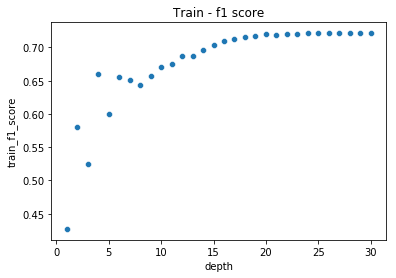

In [14]:
# check train f1 score
sns.scatterplot(x="depth", y="train_f1_score",data=perf).set_title('Train - f1 score')

Text(0.5,1,'Test - f1 score')

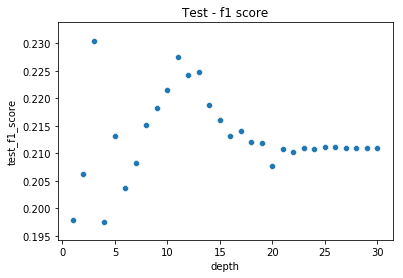

In [15]:
# check test f1 score
sns.scatterplot(x="depth", y="test_f1_score",data=perf).set_title('Test - f1 score')

Text(0.5,1,'Test/train - f1 score')

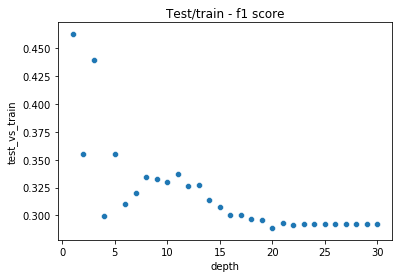

In [16]:
# check test f1 score
sns.scatterplot(x="depth", y="test_vs_train",data=perf).set_title('Test/train - f1 score')

In [17]:
# look at best values in test
perf.sort_values("test_f1_score", ascending = False).head(3)

,depth,train_f1_score,test_f1_score,test_vs_train
2,3,0.5246,0.2305,0.439382
10,11,0.6752,0.2276,0.337085
12,13,0.6865,0.2248,0.327458


In [18]:
# look at best values of ratio test/train
perf.sort_values("test_vs_train", ascending = False).head(3)

,depth,train_f1_score,test_f1_score,test_vs_train
0,1,0.4272,0.1978,0.463015
2,3,0.5246,0.2305,0.439382
1,2,0.5803,0.2062,0.355333


In [19]:
# A dummy classifier may be one that estimates 1 with probablity p = proportion of 1's in the set
#    the f1 score of this dummy classifier results to be p
# p = 0.0808 in the test set
# The maximum performance in test is observed at depth = 3
#    -> test_f1_score = 0.2305, ~185% better than the dummy estimator

# At depth = 3, test f1 score has one of the least drop offs vs train f1 score
#       model does not seem to overfit becaus it has one of the lowest value of trainning f1 score

### Select a small tree for interpretation

In [20]:
# start classifier
classifier = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 100)

# fit classifier
classifier.fit(X_train, y_train)

# predicitons
y_hat_train = classifier.predict(X_train)
y_hat_test = classifier.predict(X_test)

# f1 scores
f1_train = f1_score(y_train, y_hat_train)
f1_test = f1_score(y_test, y_hat_test)

print('Training f1 score: ' + str(round(f1_train, 4)))
print('Testing f1 score: ' + str(round(f1_test, 4)))

Training f1 score: 0.5246
Testing f1 score: 0.2305


In [21]:
# dot data
dot_data = tree.export_graphviz(classifier, 
                                feature_names=["to_user_distance", "total_earning", "ind_store_no_taken_L1H", "week_day"],
                                class_names=["taken", "no_taken"],
                                out_file=None,
                                filled=True,
                                rounded=True,
                                impurity=False,
                                proportion=True,
                                rotate=True)

In [22]:
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree_depth_4.png')


True

In [23]:
# Some insights

# In general and thinking in ralative terms

# An order is 50% more probable to not be taken when there was at least one previous not-taken order 
#.    from the same restaurant than when all orders where accepted (during L1H)

# Orders with earnings < 4k are between 25%-50% more probable to not be taken than orders w/ earnings > 4k

# Orders with to user distance < 1.2 are between 30%-50% more probable to not be taken than orders
#.    w/ to user distance > 1.2


# Whenever these three conditions hold at the same time
#     there was at least one previous not-taken order from the same restaurant (during L1H)
#     earnings < 4k
#     distance > 1.2
# Orders are ~75% more probable to not be taken
